In [1]:
import sys
import os
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if path not in sys.path:
    sys.path.append(path)

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.layers import Dense, Dropout, Embedding, LSTM, Flatten
from keras.models import Sequential
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from utils.helpers import is_it_give_information, is_question_arabic

c:\Users\nasser\.conda\envs\finall\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
df = pd.read_csv('..\data\data_for_information_classifier.csv')

In [3]:
df.head(1)

,message,reply_to,message_is_question,reply_is_question
0,الدي سي اوه مشاكل ؟؟,NaN,1,0


In [4]:
# replace nan with empty string
df = df.fillna('')

In [5]:
df.shape

(79714, 4)

In [6]:
# remove null values
df = df.dropna()

In [7]:
df.shape

(79714, 4)

In [8]:
df.sample(10).head(1)

,message,reply_to,message_is_question,reply_is_question
45470,شها؟,طوليها السجل الفلسطيني,0,0


# Label data using Regex


In [10]:
def is_giving_info(row):
    if row['reply_to'] == '':
        if row['message_is_question'] == 1:
            return 0
        else:
            if is_it_give_information(row['message']):
                return 1
            return 0
    if row['reply_is_question'] == 1:
        if row['message_is_question'] == 1:
            return 0
        else:
            if is_it_give_information(row['message']):
                return 1
            return 0
    else:
        if row['message_is_question'] == 1:
            return 0
        else:
            if is_it_give_information(row['message']):
                return 1
            return 0
            
    pass

In [11]:
df['is_giving_info'] = df.apply(lambda x : 1 if is_giving_info(x) else 0,axis=1)

In [12]:
df

,message,reply_to,message_is_question,reply_is_question,is_giving_info
0,الدي سي اوه مشاكل ؟؟,,1,0,0
1,شباب طريق جنين قلقيلة شو وضعها,,1,0,0
2,حومش شافي شمرون شو وضعهم,,1,0,0
3,صرة للداخل نابلس؟,,1,0,0
4,رام الله لنابلس,,0,0,0
...,...,...,...,...,...
79709,ماشي,حاجز حوارة حالياً,0,0,1
79710,سالك,حوارة للخارج,0,0,1
79711,نابلس للفندق الوضع,,1,0,0
79712,دير شرف للخارج ؟,,1,0,0


In [13]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate
from tensorflow.keras.models import Model

In [14]:
# Set the maximum number of words to be used in the tokenizer
MAX_NUM_WORDS = 10000

# Set the maximum length of the tokenized sequences
MAX_SEQUENCE_LENGTH = 20

In [15]:
# Split the data into training and testing sets
train_data = df.sample(frac=0.8, random_state=42)
test_data = df.drop(train_data.index)

In [16]:
# Define the tokenization function
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(train_data["message"])

In [17]:
# Convert the text data to sequences of integers
train_sequences = tokenizer.texts_to_sequences(train_data["message"])
test_sequences = tokenizer.texts_to_sequences(test_data["message"])

In [18]:
# Pad the sequences to ensure they are all the same length
train_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")
test_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")

In [19]:
# Define the inputs for the model
message_input = Input(shape=(MAX_SEQUENCE_LENGTH,), name="message_input")
reply_to_input = Input(shape=(MAX_SEQUENCE_LENGTH,), name="reply_to_input")
question_input = Input(shape=(2,), name="question_input")

In [20]:
# Define the embedding layer
embedding_layer = Embedding(MAX_NUM_WORDS, 100, input_length=MAX_SEQUENCE_LENGTH, trainable=True)


In [21]:
# Embed the message and reply_to inputs
embedded_message = embedding_layer(message_input)
embedded_reply_to = embedding_layer(reply_to_input)

In [22]:
# Concatenate the embedded message and reply_to inputs
concatenated_inputs = Concatenate(axis=1)([embedded_message, embedded_reply_to])


In [23]:
# Pass the concatenated inputs through an LSTM layer
lstm_layer = LSTM(128, return_sequences=True)
lstm_output = lstm_layer(concatenated_inputs)

In [24]:
# Add a second LSTM layer
lstm_layer2 = LSTM(128)
lstm_output2 = lstm_layer2(lstm_output)

In [25]:
# Concatenate the LSTM output with the question input
concatenated_outputs = Concatenate()([lstm_output2, question_input])

In [26]:
# Add a dense layer with 128 units
dense_layer = Dense(64, activation="relu")(concatenated_outputs)

In [27]:
# Add dropout regularization
dropout_layer = Dropout(0.2)(dense_layer)

In [28]:
# Define the output layer
output_layer = Dense(1, activation="sigmoid")(dropout_layer)

In [29]:
# Create the model
model = Model(inputs=[message_input, reply_to_input, question_input], outputs=output_layer)


In [30]:
# import Adam optimizer
from tensorflow.keras.optimizers import Adam

In [32]:
# Compile the model with custom metrics and class weights
adam = Adam()
model.compile(optimizer=adam, loss="binary_crossentropy", metrics=["accuracy"])


In [33]:
# import class weights
from sklearn.utils import class_weight

In [34]:
# Define early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss')


In [35]:
# Fit the model to the training data
history = model.fit(
    {
        "message_input": train_sequences_padded,
        "reply_to_input": train_sequences_padded,
        "question_input": np.array(train_data[["message_is_question", "reply_is_question"]])
    },
    np.array(train_data["is_giving_info"]),
    epochs=20,
    batch_size=4096,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/20
13/13 [==============================] - 5s 123ms/step - loss: 0.6684 - accuracy: 0.5559 - val_loss: 0.6392 - val_accuracy: 0.5871
Epoch 2/20
13/13 [==============================] - 1s 81ms/step - loss: 0.6352 - accuracy: 0.6066 - val_loss: 0.6135 - val_accuracy: 0.6018
Epoch 3/20
13/13 [==============================] - 1s 80ms/step - loss: 0.4974 - accuracy: 0.7633 - val_loss: 0.3495 - val_accuracy: 0.8505
Epoch 4/20
13/13 [==============================] - 1s 80ms/step - loss: 0.2423 - accuracy: 0.9136 - val_loss: 0.1842 - val_accuracy: 0.9328
Epoch 5/20
13/13 [==============================] - 1s 81ms/step - loss: 0.1410 - accuracy: 0.9567 - val_loss: 0.1826 - val_accuracy: 0.9312
Epoch 6/20
13/13 [==============================] - 1s 80ms/step - loss: 0.1000 - accuracy: 0.9711 - val_loss: 0.1420 - val_accuracy: 0.9581
Epoch 7/20
13/13 [==============================] - 1s 80ms/step - loss: 0.0694 - accuracy: 0.9812 - val_loss: 0.1389 - val_accuracy: 0.9581
Epoch 8/20
1

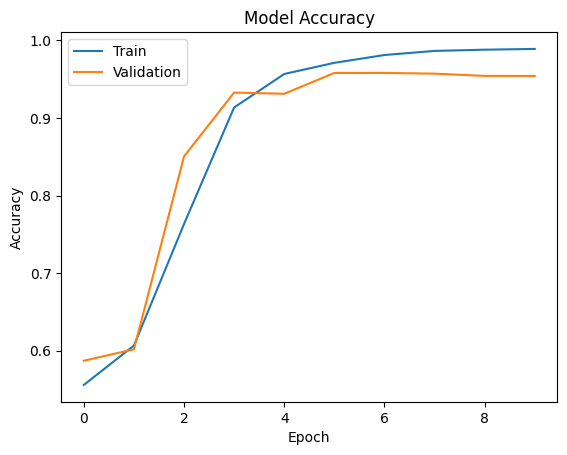

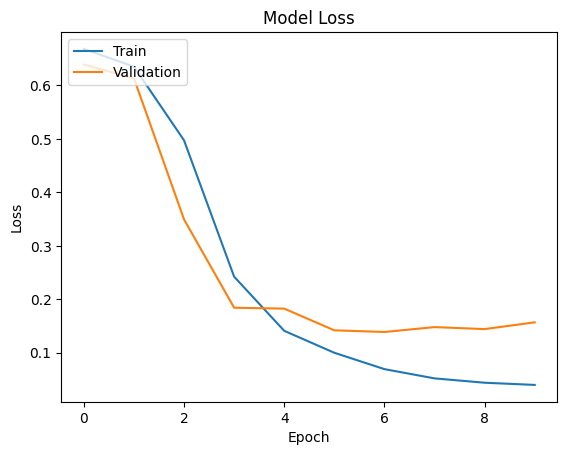

In [38]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



In [44]:
# test the model on the test data
new_df = pd.DataFrame({
    "message": ["كبف حوارة؟"],
    "reply_to": ["سالكة"],
    "message_is_question": [1],
    "reply_is_question": [1]
})
# Convert the text data to sequences of integers
new_sequences = tokenizer.texts_to_sequences(new_df["message"])
new_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(new_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")
# do the same for the reply_to column
new_sequences2 = tokenizer.texts_to_sequences(new_df["reply_to"])
new_sequences_padded2 = tf.keras.preprocessing.sequence.pad_sequences(new_sequences2, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")
# predict the output
model.predict([new_sequences_padded, new_sequences_padded2, np.array(new_df[["message_is_question", "reply_is_question"]])])

1/1 [==============================] - 0s 20ms/step


array([[0.00073045]], dtype=float32)

In [45]:
# save the model and tokenizer
model.save("../models/information_classifier.h5")
# save the tokenizer
import joblib
joblib.dump(tokenizer, "..\models\information_tokenizer.joblib")


['..\\models\\information_tokenizer.joblib']